### Evaluation notebook

Evaluates on `HPatches` dataset.

For an R2D2-like model, given that you have run the inference script `relfm/inference/r2d2_on_hpatches.py` that generates outputs, you can run this notebook to test rotation equivariance of local feature matching.

## Table of Contents

* [Imports](#imports)
* [Configure inputs](#configure_inputs)
* [Generate results](#generate_results)
* [Plot results](#plot_results)

> *Warning*: This notebook takes about 9-10 minutes for generating results per model.

### Imports <a class="anchor" id="imports"></a>

Basic imports.
> Note that you should set `PYTHONPATH=/path/to/repo/:/path/to/repo/lib/r2d2/` before running the environment.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join, exists, expanduser
from genericpath import isdir
from glob import glob
import numpy as np
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt
import torch

from lib.r2d2.extract import extract_keypoints_modified
from relfm.utils.paths import REPO_PATH
from relfm.utils.log import print_update, tqdm_iterator
from relfm.utils.visualize import show_images_with_keypoints, set_latex_fonts
from relfm.utils.matching import evaluate_matching_with_rotation, analyze_result
from relfm.inference.r2d2_on_hpatches import configure_save_dir

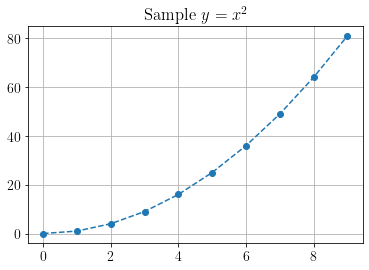

In [3]:
set_latex_fonts(show_sample=True)

### Configure inputs <a class="anchor" id="configure_inputs"></a>

Set the correct data and output paths as well as the model checkpoint that you'd like to evaluate on. Parameters such as `gap_between_rotations` and `imsize` (size of downsized image to evaluate) are hard-coded to be the same as the default values in the inference script.

In [4]:
data_dir = join(REPO_PATH, "data/hpatches-sequences-release/")

model_ckpt_paths = {
    "R2D2": join(REPO_PATH, "checkpoints/r2d2_WASF_N16.pt"),
    "R2D2 - $C_{4}$": join(REPO_PATH, "trained_models/epoch_16_test_model.pt"),
}
# model_ckpt_path = join(REPO_PATH, "checkpoints/r2d2_WASF_N16.pt")
# model_ckpt_path = join(REPO_PATH, "trained_models/epoch_16_test_model.pt")

output_dir = join(expanduser("~"), "outputs/rotation-equivariant-lfm")

In [5]:
assert isdir(data_dir)
assert isdir(output_dir)
# assert exists(model_ckpt_path)

gap_between_rotations=15
downsize=True
imsize=300

### Generate results <a class="anchor" id="generate_results"></a>

In [6]:
results = dict()

for model_name, model_ckpt_path in model_ckpt_paths.items():

    # save directory
    save_dir = configure_save_dir(output_dir, model_ckpt_path, dataset_name="hpatches")

    metrics_path = join(save_dir, "metrics.pt")
    if exists(metrics_path):
        print_update(f"Loading cached results for {model_name}")
        results[model_name] = torch.load(metrics_path)["MMA"]
        continue
    
    print_update(f"Generating results for {model_name}")

    # load image sequences
    sequences = sorted(glob(join(data_dir, "*")))

    # load rotation values between 0 and 360 degrees
    rotations = np.arange(0, 360 + 1, gap_between_rotations, dtype=int)

    # set a (list of) pixel threshold value across which to evaluate rotation robustness
    thresholds = [3.]

    # set this to true to see intermediate outputs/messages
    verbose = False

    # computing Mean Matching Accuracy (MMA)
    mma = defaultdict(list)
    counter = 1
    for sequence in sequences:
        # set path to the source image
        img1_path = join(sequence, "1.ppm")
        img1 = Image.open(img1_path)
        if downsize:
            img1 = img1.resize((imsize, imsize))

        # load outputs for source image
        sequence_name = os.path.basename(sequence)
        save_path = join(save_dir, sequence_name, "1.npy")
        img1_outputs = np.load(save_path, allow_pickle=True).item()

        # possible indices of the target images
        img2_indices = np.arange(2, 7)

        # load all target images at once
        img2s = [Image.open(join(sequence, f"{i}.ppm")) for i in img2_indices]
        if downsize:
            img2s = [img2.resize((imsize, imsize)) for img2 in img2s]

        # load all homographies
        # NOTE that this is not needed since we save the apt H within outputs itself

        rotation_grid, img2_indices_grid  = np.meshgrid(rotations, img2_indices)
        rotation_grid, img2_indices_grid = rotation_grid.flatten(), img2_indices_grid.flatten()

        iterator = tqdm_iterator(
            range(len(rotation_grid)),
            desc=f"Evaluating predictions for {sequence_name} ({counter}/{len(sequences)})\t\t",
        )
        for i in iterator:
            rotation, img2_index = rotation_grid[i], img2_indices_grid[i]

            if verbose:
                print(f"Image {img2_index} with rotation {rotation}")

            img2 = img2s[img2_index - 2]
            img2_rotated = img2.rotate(rotation)

            save_path = join(save_dir, sequence_name, f"{img2_index}_rotation_{rotation}.npy")
            img2_outputs = np.load(save_path, allow_pickle=True).item()

            # get keypoints and descriptors from the outputs
            kps1 = img1_outputs["keypoints"]
            des1 = img1_outputs["descriptors"]

            kps2 = img2_outputs["keypoints"]
            des2 = img2_outputs["descriptors"]
            H = img2_outputs["H"]

            # show detected keypoints
            if verbose and rotation == 30 and img2_index == 4:
                show_images_with_keypoints([img1, img2_rotated], [kps1, kps2], radius=2)

            # perform matching
            width, height = img2.size
            result = evaluate_matching_with_rotation(
                kp1=kps1,
                des1=des1,
                kp2=kps2,
                des2=des2,
                H=H,
                width=width,
                height=height,
                rotation=rotation,
                return_metadata=True,
                threshold=3.,
            )

            # show matching results
            if verbose and rotation == 30 and img2_index == 4:
                analyze_result(img1, img2_rotated, result, K=10, radius=5)

            # compute accuracy across various thresholds
            _match_accu = []
            for threshold in thresholds:
                _match_accu.append(np.mean(result["distances"] < threshold))

            mma[rotation].append(np.mean(_match_accu))

        counter += 1

    # compute the mean matching accuracy (MMA) for every rotation value
    mma_avg = {k:np.array(mma[k]).mean() for k in mma}
    # save metrics
    metrics = {
        "MMA": mma_avg,
    }
    torch.save(metrics, metrics_path)
    
    # collect results
    results[model_name] = mma_avg

::::::::::::::::::::::::::::::::::::::::::::::::::::: Loading cached results for R2D2 ::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::::::::::::::: Loading cached results for R2D2 - $C_{4}$ :::::::::::::::::::::::::::::::::::::::::::::::::


### Plot results <a class="anchor" id="plot_results"></a>

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


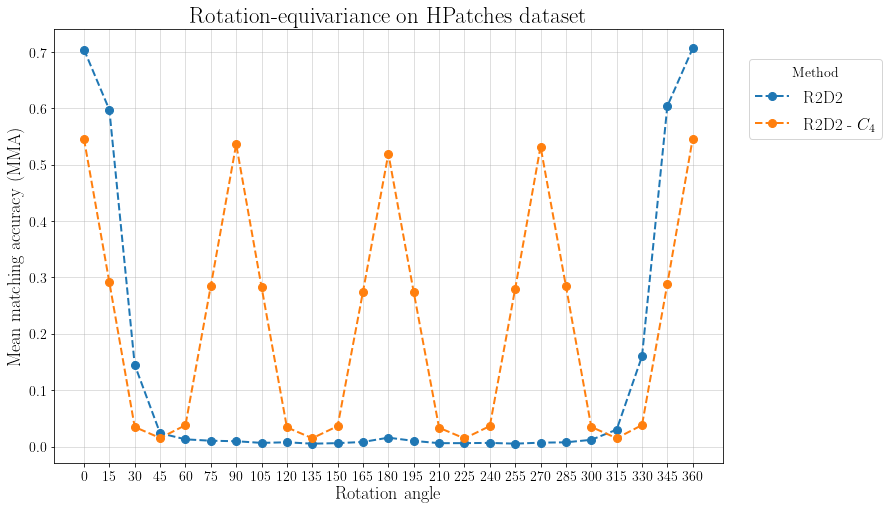

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.grid(alpha=0.5)
# ax.set_ylim((0., 1.))
ax.set_title("Rotation-equivariance on HPatches dataset", fontsize=23)
ax.set_xlabel("Rotation angle ", fontsize=18)
ax.set_ylabel("Mean matching accuracy (MMA)", fontsize=18)

for model_name, mma_avg in results.items():

    ax.plot(
        list(mma_avg.keys()),
        list(mma_avg.values()),
        "--o",
        label=model_name,
        markersize=8,
        linewidth=2.,
    )
    ax.set_xticks(list(mma_avg.keys()))

ax.legend(fontsize=17, bbox_to_anchor=(1.25, 0.95), title="Method",)
plt.show()